### 과적합 해결

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

### 배치 정규화 적용

In [33]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [34]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [35]:
# 데이터 분할

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [36]:
class SimpleNN(nn.Module):
    def __init__(self, use_bn=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)                 # 평탄화, (배치크기, h, w) -> (배치크기, feature_size)
        x = torch.relu(self.bn1(self.fc1(x)))     # 활성화 함수 적용
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [37]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()                   # 손실 함수 초기화, CrossEntropyLoss는 분류 문제에서 사용
    optimizer = optim.Adam(model.parameters(), lr=0.01) # 최적화 알고리즘 초기화

    for epoch in range(epochs):
        # 학습 모드로 전환
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)    # 평탄화, 이미지 텐서를 벡터로 변환
            optimizer.zero_grad()
            outputs = model(images)                     # 모델 출력 계산, 내부적으로 model.forward(images) 호출
            loss = criterion(outputs, labels)           # 손실 계산
            loss.backward()                             # 역전파
            optimizer.step()                            # 가중치 업데이트

        # 검증 모드로 전환
        model.eval()
        val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        print(f"Epoch {epoch+1}/{epochs} | Val loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_data):4f}")

In [43]:
print("배치 정규화 적용 안함")
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print("\n배치 정규화 적용")
model_with_bn = SimpleNN(use_bn=True)
train(model_with_bn, train_loader, val_loader)

배치 정규화 적용 안함
Epoch 1/5 | Val loss: 0.2906, Accuracy: 0.908250
Epoch 2/5 | Val loss: 0.3143, Accuracy: 0.908917
Epoch 3/5 | Val loss: 0.2545, Accuracy: 0.930833
Epoch 4/5 | Val loss: 0.2978, Accuracy: 0.909917
Epoch 5/5 | Val loss: 0.2287, Accuracy: 0.936833

배치 정규화 적용
Epoch 1/5 | Val loss: 0.1253, Accuracy: 0.961583
Epoch 2/5 | Val loss: 0.1033, Accuracy: 0.968667
Epoch 3/5 | Val loss: 0.0863, Accuracy: 0.972667
Epoch 4/5 | Val loss: 0.0822, Accuracy: 0.976333
Epoch 5/5 | Val loss: 0.0830, Accuracy: 0.977250


In [39]:
for batch_size in [16, 32, 128]:
    print(f"batch_size: {batch_size}")
    train_loader = DataLoader(train_data, batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

batch_size: 16
Epoch 1/5 | Val loss: 0.1296, Accuracy: 0.961167
Epoch 2/5 | Val loss: 0.1271, Accuracy: 0.961083
Epoch 3/5 | Val loss: 0.1140, Accuracy: 0.963917
Epoch 4/5 | Val loss: 0.0891, Accuracy: 0.972500
Epoch 5/5 | Val loss: 0.0825, Accuracy: 0.974583
batch_size: 32
Epoch 1/5 | Val loss: 0.1173, Accuracy: 0.962083
Epoch 2/5 | Val loss: 0.0977, Accuracy: 0.969333
Epoch 3/5 | Val loss: 0.0921, Accuracy: 0.970500
Epoch 4/5 | Val loss: 0.0983, Accuracy: 0.971167
Epoch 5/5 | Val loss: 0.0812, Accuracy: 0.977083
batch_size: 128
Epoch 1/5 | Val loss: 0.1265, Accuracy: 0.959167
Epoch 2/5 | Val loss: 0.1004, Accuracy: 0.968750
Epoch 3/5 | Val loss: 0.0984, Accuracy: 0.970750
Epoch 4/5 | Val loss: 0.1024, Accuracy: 0.968417
Epoch 5/5 | Val loss: 0.0977, Accuracy: 0.971833


### Dropout 적용

In [ ]:
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))        # train 할때는 dropout 적용 o -> 랜덤한 뉴런이 비활성화, 
        x = torch.relu(self.dropout2(self.fc2(x)))        # eval 할때는 dropout 적용 x -> 모든 뉴런 학습, full connection -> relu 적용
        x = self.fc3(x)
        return x

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# dropout_rate 커진다 -> 더 많은 뉴런을 끈다 : 강한 정규화
for rate in [0.2, 0.5, 0.8]:
    print(f"Dropout rate: {rate}")
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

Dropout rate: 0.2
Epoch 1/5 | Val loss: 0.3565, Accuracy: 0.901333
Epoch 2/5 | Val loss: 0.3210, Accuracy: 0.909167
Epoch 3/5 | Val loss: 0.2751, Accuracy: 0.922250
Epoch 4/5 | Val loss: 0.3561, Accuracy: 0.903250
Epoch 5/5 | Val loss: 0.3298, Accuracy: 0.911583
Dropout rate: 0.5
Epoch 1/5 | Val loss: 0.7270, Accuracy: 0.837000
Epoch 2/5 | Val loss: 0.8080, Accuracy: 0.751083
Epoch 3/5 | Val loss: 0.7510, Accuracy: 0.823583
Epoch 4/5 | Val loss: 0.6892, Accuracy: 0.821417
Epoch 5/5 | Val loss: 0.7594, Accuracy: 0.801083
Dropout rate: 0.8
Epoch 1/5 | Val loss: 2.3016, Accuracy: 0.114250
Epoch 2/5 | Val loss: 2.3015, Accuracy: 0.114250
Epoch 3/5 | Val loss: 2.3033, Accuracy: 0.103000
Epoch 4/5 | Val loss: 2.3022, Accuracy: 0.114250
Epoch 5/5 | Val loss: 2.3023, Accuracy: 0.114250


In [ ]:
# 훈련/ 학습 시는 dropout 가능 o
# 테스트/ 검증 시에는 dropout x, 모든 뉴런 학습

In [44]:
model = DropoutNN(dropout_rate=0.2)

In [ ]:
model.eval()                             # eval: dropout 적용 x -> 모든 뉴런 학습, 그래서 결과가 같음
with torch.no_grad():                    # 따라서 allclose : True
    images, _ = next(iter(val_loader))
    images = images.view(images.size(0), -1)

    out1 = model(images)
    out2 = model(images)

    print(torch.allclose(out1, out2))    # allclose : 두 텐서가 같은지 확인

True


In [ ]:
model.train()                             # train 할때는 dropout 적용 o -> 랜덤한 뉴런이 비활성화, 그래서 결과가 다르게 나옴
                                          # 따라서 allclose : False
out1 = model(images)
out2 = model(images)

print(torch.allclose(out1, out2))

False


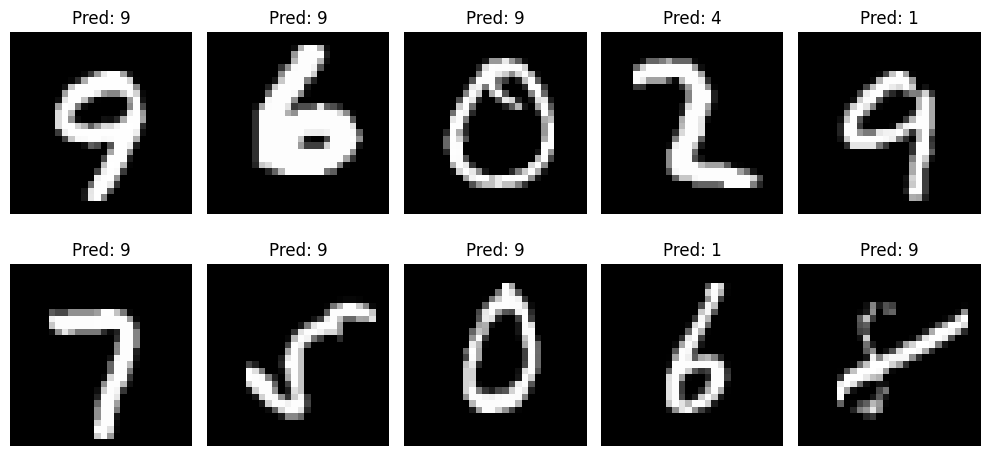

In [45]:
model.eval()
with torch.no_grad():
    images, _ = next(iter(val_loader))
    images = images.view(images.size(0), -1)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].view(28, 28).cpu().numpy(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Learning Rate Scheduler 적용

In [49]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [52]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()                   # 손실 함수 초기화, CrossEntropyLoss는 분류 문제에서 사용

    for epoch in range(epochs):
        # 학습 모드로 전환
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)    # 평탄화, 이미지 텐서를 벡터로 변환
            optimizer.zero_grad()
            outputs = model(images)                     # 모델 출력 계산, 내부적으로 model.forward(images) 호출
            loss = criterion(outputs, labels)           # 손실 계산
            loss.backward()                             # 역전파
            optimizer.step()                            # 가중치 업데이트

        # 검증 모드로 전환
        model.eval()
        val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} | Val loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_data):4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

In [53]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
train_lr(model, train_loader, val_loader, optimizer, scheduler)

Epoch 1/10 | Val loss: 0.2969, Accuracy: 0.906167, Learning Rate: 0.010000
Epoch 2/10 | Val loss: 0.2929, Accuracy: 0.912500, Learning Rate: 0.010000
Epoch 3/10 | Val loss: 0.2894, Accuracy: 0.920417, Learning Rate: 0.001000
Epoch 4/10 | Val loss: 0.1494, Accuracy: 0.955167, Learning Rate: 0.001000
Epoch 5/10 | Val loss: 0.1364, Accuracy: 0.960000, Learning Rate: 0.001000
Epoch 6/10 | Val loss: 0.1345, Accuracy: 0.960250, Learning Rate: 0.000100
Epoch 7/10 | Val loss: 0.1295, Accuracy: 0.962917, Learning Rate: 0.000100
Epoch 8/10 | Val loss: 0.1284, Accuracy: 0.962583, Learning Rate: 0.000100
Epoch 9/10 | Val loss: 0.1282, Accuracy: 0.963167, Learning Rate: 0.000010
Epoch 10/10 | Val loss: 0.1279, Accuracy: 0.964000, Learning Rate: 0.000010
